In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from cfg import *
from dataset import MyDataset
from torch.utils.data import DataLoader
from utils import *

In [3]:
voc_data = MyDataset('/home/lyzustc/programs/mydataset/train.txt', dataset = 'mydataset', is_train=True)
voc_loader = DataLoader(dataset = voc_data, shuffle = True, batch_size = 10)
voc_iter = iter(voc_loader)

In [3]:
class_names = load_class_names('data/mydataset.names')
img, label = next(voc_iter)
img_np = np.transpose(img[0].numpy(),(1,2,0))
cv2.imshow('ori1',img_np)
img_gt_np = plot_gt_boxes(img_np.copy(), label[0].view(-1,5), class_names)
cv2.imshow('gt1',img_gt_np)
cv2.waitKey(0)

113

torch.Size([10, 3, 416, 416])
torch.Size([10, 250])
tensor([[ 4.0000,  0.6564,  0.5820,  0.2945,  0.4317]])
tensor([[ 2.0000,  0.2415,  0.5771,  0.2627,  0.4813]])
tensor([[ 1.0000,  0.5281,  0.6968,  0.8839,  0.4894]])
tensor([[ 5.0000,  0.5664,  0.5000,  0.3984,  0.5677]])
tensor([[ 4.0000,  0.3321,  0.5870,  0.3212,  0.4239]])
tensor([[ 0.0000,  0.4521,  0.5612,  0.7871,  0.3776]])
tensor([[ 1.0000,  0.4762,  0.5000,  0.4444,  0.5211]])
tensor([[ 4.0000,  0.4826,  0.5155,  0.6255,  0.4742]])
tensor([[ 1.0000,  0.5362,  0.4793,  0.8224,  0.7337]])
tensor([[ 5.0000,  0.4980,  0.4753,  0.2656,  0.6641]])


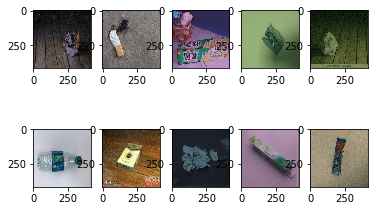

In [5]:
img,label = next(voc_iter)
print(img.size())
print(label.size())
for index in np.arange(img.shape[0]):
    img_np = np.transpose(img[index].numpy(),(1,2,0))
    plt.subplot(2,5,index + 1)
    plt.imshow(img_np)
    tmp = torch.nonzero(label[index])
    print(label[index][0:tmp[-1]+1].view(-1,5))

In [1]:
from cfg import *
blocks = parse_cfg('./cfg/yolo_v3.cfg')

In [2]:
for block in blocks:
    print(block)

{'type': 'net', 'batch': '1', 'subdivisions': '1', 'width': '416', 'height': '416', 'channels': '3', 'momentum': '0.9', 'decay': '0.0005', 'angle': '0', 'saturation': '1.5', 'exposure': '1.5', 'hue': '.1', 'learning_rate': '0.001', 'burn_in': '1000', 'max_batches': '500200', 'policy': 'steps', 'steps': '400000,450000', 'scales': '.1,.1'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '32', 'size': '3', 'stride': '1', 'pad': '1', 'activation': 'leaky'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '3', 'stride': '2', 'pad': '1', 'activation': 'leaky'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '32', 'size': '1', 'stride': '1', 'pad': '1', 'activation': 'leaky'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '3', 'stride': '1', 'pad': '1', 'activation': 'leaky'}
{'type': 'shortcut', 'from': '-3', 'activation': 'linear'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '128', 'size': '3', 

In [1]:
from darknet import Darknet

In [2]:
net = Darknet('./cfg/yolo_v3.cfg')

In [3]:
net.load_weights('./weights/darknet53.conv.74')

In [4]:
net.save_weights('./weights/save.weights',-1)

In [5]:
net2 = Darknet('./cfg/yolo_v3.cfg')

In [6]:
net2.load_weights('./weights/save.weights')

In [1]:
import train

In [10]:
import torch
from darknet import Darknet
from dataset import MyDataset
from torchvision import datasets, transforms
from utils import *
import os
import time

options = read_data_cfg('cfg/voc.data')
valid_images = options['valid']
name_list = options['names']

names = load_class_names(name_list)

with open(valid_images) as fp:
    tmp_files = fp.readlines()
    valid_files = [item.rstrip() for item in tmp_files]

m = Darknet('cfg/yolo_v3_voc.cfg')
m.cuda()
m.eval()
m.load_weights('weights/epoch48_voc.weights')
num_classes = len(names)

valid_dataset = MyDataset(valid_images, shape=(m.width, m.height),
                       is_train = False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ]))
valid_batchsize = 1
kwargs = {'num_workers': 4, 'pin_memory': True}
valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=valid_batchsize, shuffle=False, **kwargs)

valid_iter = iter(valid_loader)




In [11]:
data, label = next(valid_iter)

conf_thresh = 0.3
nms_thresh = 0.45
data = data.cuda()
output = m(data)

In [12]:
batch_boxes = get_all_boxes(output, conf_thresh, num_classes, only_objectness=0, validation=True, use_cuda = True)
boxes = batch_boxes[0]
start = time.time()
for cls_id in range(num_classes):
    cls_ind = boxes[:,6] == cls_id

    b = boxes[cls_ind]
    c = nms(b,nms_thresh)
    print(c)
end = time.time()
print('nms time {}s'.format(end-start))

tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([[  0.3451,   0.6527,   0.4469,   0.3730,   0.3119,   0.9941,
          11.0000]])
tensor([])
tensor([])
tensor([[  0.5865,   0.4873,   1.0439,   1.0640,   0.7096,   0.9911,
          14.0000]])
tensor([])
tensor([])
tensor([])
tensor([])
tensor([])
nms time 0.01126408576965332s


In [3]:
def nms2(boxes, nms_thresh):
    if boxes.shape[0] == 0:
        return boxes

    det_confs = boxes[:,4] * boxes[:,5]               

    _, sortIds = torch.sort(det_confs, descending = True)
    boxes = boxes[sortIds]
    ind_mask = torch.ones(sortIds.shape).float()
    for i in range(boxes.shape[0] - 1):
        tmp_ind = torch.nonzero(ind_mask[i+1:]).squeeze(0)
        if tmp_ind.numel() != 0:
            tmp_boxes = boxes[tmp_ind + i + 1].view(-1, boxes.shape[1])
            ious = multi_bbox_ious(boxes[i].repeat(tmp_boxes.shape).t(), tmp_boxes.t(), x1y1x2y2 = False)
            tmp_ind = tmp_ind[ious > nms_thresh]
            ind_mask[i+1:][tmp_ind] = 0
    
    masked_inds = torch.nonzero(ind_mask).squeeze()
    return boxes[masked_inds]

tensor([[ 11.0000,   0.3442,   0.6110,   0.4164,   0.2620,  14.0000,
           0.5099,   0.5100,   0.9745,   0.9720,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0

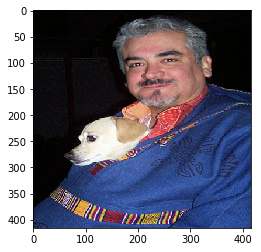

In [15]:
import matplotlib.pyplot as plt
img_np = np.transpose(data[0].cpu().numpy(),(1,2,0))
plt.imshow(img_np)
print(label)

In [39]:
a = torch.Tensor([0,0,0])
c = torch.nonzero(a)
c.numel()

0

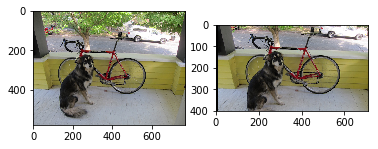

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
img = Image.open('data/dog.jpg').convert('RGB')
plt.subplot(1,2,1)
plt.imshow(img)
croped = img.crop((-10,100,700,500))
plt.subplot(1,2,2)
plt.imshow(croped)

In [7]:
import cv2
video_file = 'data/5.mp4'
cap = cv2.VideoCapture(video_file)
frame_no = 0
while cap.isOpened():
    ret,frame = cap.read()
    if ret:
        cv2.imwrite('video_frames/frame{}.jpg'.format(frame_no), frame)
    else:
        break
    frame_no += 1